In [1]:
import numpy as np
import matplotlib.pylab as plt

from mpl_toolkits.mplot3d import Axes3D

## 4.3.2 수치 미분의 예
$y = 0.01 x^2 + 0.1 x$

0.1999999999990898


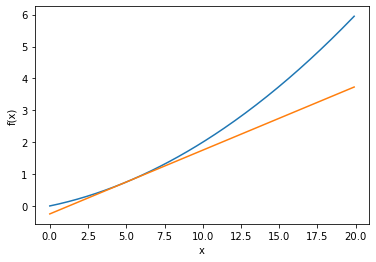

In [2]:
# gradient_1d.py
def function_1(x):
    return 0.01*x**2 + 0.1*x 


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)

## 4.4 기울기 (gradient)
$ f(x_0,x_1) = x_0^2 + x_1^2$

In [3]:
# gradient_2d.py
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

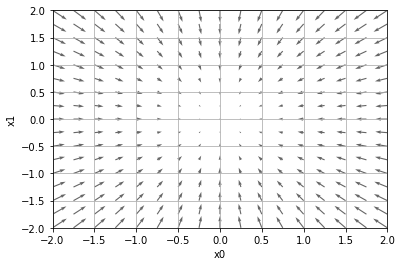

In [4]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
# plt.legend()
plt.draw()
plt.show()

## 4.4.1 경사법 (경사 하강법)

Text(0, 0.5, 'X1')

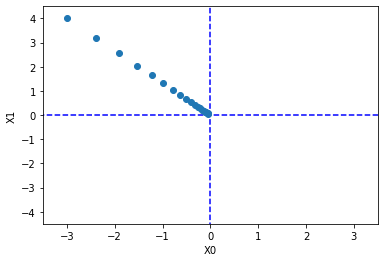

In [5]:
# gradient_method.py
# def function_2(x):
#     return x[0]**2 + x[1]**2

# from gradient_2d import numerical_gradient
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")

## 4.4.2 신경망에서의 기울기

In [6]:
# gradient_simplenet.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)    # w is dummy
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.48188739  0.11172472 -0.59361211]
 [ 0.72283108  0.16758708 -0.89041816]]


In [7]:
net.loss(x,t)

4.543389742843151

## 4.5.1 2층 신경망 클래스 구현하기

In [8]:
# two_layer_net.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [9]:
# 사용 예
net = TwoLayerNet(input_size=64, hidden_size=20, output_size=5)
net.params

{'W1': array([[ 0.00440611, -0.00077776,  0.01812067, ...,  0.0083983 ,
          0.01821592,  0.00481196],
        [ 0.00721303, -0.00417156, -0.00757775, ...,  0.03580925,
          0.00344199, -0.00515682],
        [ 0.00704982, -0.00029196,  0.00204532, ..., -0.02013674,
         -0.00617459,  0.01487139],
        ...,
        [-0.00414319, -0.00613353, -0.00927822, ...,  0.00709922,
         -0.02120792,  0.00099669],
        [ 0.01833069,  0.00566295,  0.01103368, ...,  0.01543835,
          0.01176723, -0.00036284],
        [ 0.00064637, -0.00021577, -0.01030483, ..., -0.01774464,
         -0.0183369 , -0.00963193]]),
 'b1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'W2': array([[ 8.25199661e-03, -1.26276499e-02,  5.78462859e-04,
         -8.05627176e-05, -1.47096041e-02],
        [-3.68622851e-03,  1.13522548e-03, -4.94487523e-03,
          8.70270394e-03, -1.28406095e-02],
        [-1.46002454e-02,  6.31101910e-03,  1.061

<BarContainer object of 5 artists>

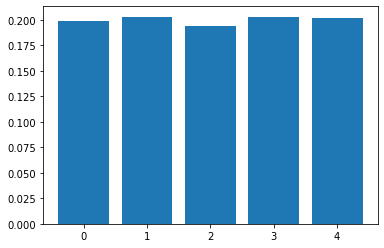

In [10]:
# forward prop
x = np.random.rand(100,64)
y = net.predict(x)

plt.bar(np.arange(0,5), y[0])

In [11]:
%%time
# calc numerical gradient
t = np.random.rand(100,5)
numerical_grads = net.numerical_gradient(x, t)
numerical_grads

CPU times: user 1.92 s, sys: 226 ms, total: 2.14 s
Wall time: 865 ms


{'W1': array([[ 7.68848374e-05,  1.65960812e-05, -1.93471450e-05, ...,
         -8.23239643e-05, -3.21239590e-06, -5.96308070e-05],
        [ 4.94910202e-05, -2.51380405e-05, -4.36767889e-05, ...,
         -2.90325530e-05,  3.27656902e-05,  1.68466630e-05],
        [ 2.09935384e-04,  9.21467402e-05, -2.12443274e-04, ...,
         -1.98545974e-04,  3.61461039e-05, -1.42029513e-04],
        ...,
        [ 9.99952932e-05, -5.06976394e-05, -4.19815560e-05, ...,
         -7.70155562e-05,  4.71486117e-05,  7.82030773e-06],
        [ 1.35003986e-05, -1.86100135e-05,  3.32144645e-06, ...,
          5.91614446e-05, -1.37262723e-05,  7.29053828e-05],
        [-6.67239830e-05, -1.22165907e-04,  6.93781355e-05, ...,
          1.73083209e-04,  1.72574599e-05,  2.16541794e-04]]),
 'b1': array([ 1.33453170e-04, -6.21611163e-05, -7.67453945e-05, -8.98833985e-05,
        -9.60263502e-05, -2.50384646e-05, -1.02250988e-04,  5.28817867e-05,
        -2.41174880e-05, -1.84344456e-04, -3.49078078e-05, -1.329

In [12]:
%%time
grads = net.gradient(x, t)
grads

CPU times: user 8.54 ms, sys: 4.91 ms, total: 13.5 ms
Wall time: 6.34 ms


{'W2': array([[-0.15584248, -0.13615229, -0.14498595, -0.16178878, -0.1454928 ],
        [-0.16061325, -0.1408211 , -0.14949155, -0.16672896, -0.15040972],
        [-0.15630022, -0.13637269, -0.14516842, -0.16186085, -0.14602683],
        [-0.15947559, -0.13996274, -0.14832396, -0.1655041 , -0.14940003],
        [-0.15305794, -0.13399143, -0.14217345, -0.15859476, -0.14325636],
        [-0.15167479, -0.13260165, -0.14084298, -0.15720426, -0.14165642],
        [-0.163075  , -0.1421599 , -0.1512481 , -0.16858658, -0.15271197],
        [-0.15690836, -0.13769194, -0.14591069, -0.16277927, -0.14714356],
        [-0.15222704, -0.13268245, -0.14129581, -0.15740342, -0.14219465],
        [-0.15276314, -0.13396869, -0.14227631, -0.15859873, -0.14300092],
        [-0.15559051, -0.13613635, -0.14464424, -0.16155099, -0.14551667],
        [-0.15958573, -0.13956933, -0.14817567, -0.16552411, -0.14941588],
        [-0.15819552, -0.13857089, -0.14726065, -0.1641015 , -0.14812255],
        [-0.1554512

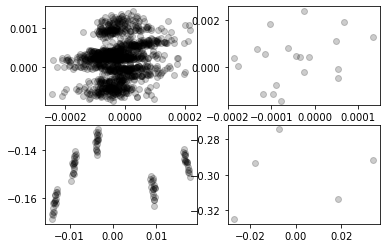

In [13]:
# 비교
plt.subplot(221)
plt.scatter(numerical_grads['W1'], grads['W1'], alpha=0.2, c='k')
plt.subplot(222)
plt.scatter(numerical_grads['b1'], grads['b1'], alpha=0.2, c='k')
plt.subplot(223)
plt.scatter(numerical_grads['W2'], grads['W2'], alpha=0.2, c='k')
plt.subplot(224)
plt.scatter(numerical_grads['b2'], grads['b2'], alpha=0.2, c='k')

## MNIST 데이터로 학습 (4.5.2 미니배치 학습 구현하기 / 4.5.3 시험 데이터로 평가하기)

In [14]:
# train_neuralnet.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)   # TOO SLOW TO RUN
    grad = network.gradient(x_batch, t_batch)    # faster! (Next chapter)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.7993166666666667, 0.8031
train acc, test acc | 0.8795, 0.8842
train acc, test acc | 0.8997166666666667, 0.9018
train acc, test acc | 0.90875, 0.9125
train acc, test acc | 0.9156333333333333, 0.9184
train acc, test acc | 0.9204333333333333, 0.923
train acc, test acc | 0.92365, 0.9253
train acc, test acc | 0.9276666666666666, 0.9288
train acc, test acc | 0.9309166666666666, 0.933
train acc, test acc | 0.93425, 0.9351
train acc, test acc | 0.9377166666666666, 0.9375
train acc, test acc | 0.9392666666666667, 0.9392
train acc, test acc | 0.9416333333333333, 0.9411
train acc, test acc | 0.9439666666666666, 0.9439
train acc, test acc | 0.94565, 0.9455
train acc, test acc | 0.9467833333333333, 0.9464


Text(0, 0.5, 'loss')

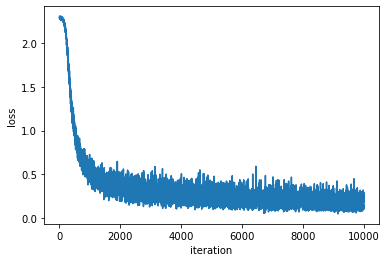

In [15]:
# 손실 함수
plt.plot(train_loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')

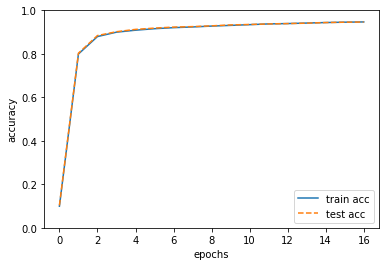

In [16]:
# 정확도 그래프
# markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()